In [1]:
import matplotlib.pyplot as plt
import numpy as np
from molecular_simulations.utils import writeXYZ, Accumulator

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [2]:
from typing import Tuple

import numpy as np
from numba import njit

from molecular_simulations.utils import (
    apply_bc,
    dist,
    initialise_lattice,
    initialise_velocities,
)


def lj_md(
    N: int,
    rho: float,
    T: float,
    dt: float,
    eqnum: int = 100,  # Equilibration steps
    snum: int = 1000,  # Sampling steps
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    np.random.seed(42)
    # Reduced units:
    # epsilon (energy)
    # sigma (length)
    # m (mass)

    # U* = U * epsilon
    # T* = kb * T / epsilon
    # P* = P * sigma^3 / epsilon
    # rho* = rho * sigma^3

    V = N / rho
    L = V ** (1 / 3)
    cutoff = 2.5  # cutoff
    cutoff_sq = cutoff**2
    # Tail of the energy contribution due to truncation
    tail_e = ((1 / cutoff_sq) ** 6 - (1 / cutoff_sq) ** 3)

    def single_force(
        dists: np.ndarray,
        delta_pos: np.ndarray,
        forces: np.ndarray,
    ) -> Tuple[float, np.ndarray]:
        # Apply cutoff as boolean mask & calculate all single energy contributions
        rc = dists < cutoff_sq
        r2 = 1 / dists[rc]
        r6 = r2**3
        en = r6 * (r6 - 1)
        term = r2 * r6 * (r6 - 0.5)
        ff = (
            delta_pos[rc] * term[:, None]
        )  # Forces on particle i by all remaining pairs
        forces[rc] -= ff  # Substract ff to the forces array (3rd law)

        return en.sum() - tail_e*rc.sum(), ff.sum(axis=0)

    def update_forces(positions: np.ndarray, forces: np.ndarray) -> float:
        en = 0
        forces[:] = 0
        for i in range(N - 1):
            # Calculate the force on particle i (and the energy)
            particle = positions[i]
            delta_pos, dists = dist(positions[i + 1 :], particle, L)
            eni, fi = single_force(dists, delta_pos, forces[i + 1 :])
            # Update energy and forces
            en += eni
            forces[i] += fi
        return en
    
    def integrate(
        positions: np.ndarray,
        positions_o: np.ndarray,
        velocities: np.ndarray,
        forces: np.ndarray,
    ):
        positions_n = 2 * positions - positions_o + dt**2 * 48 * forces  # Verlet
        velocities[:] = (positions_n - positions_o) / (2 * dt)  # Velocity
        # Update
        positions_o[:] = positions[:]
        positions[:] = positions_n[:]
    

    def md_loop(positions: np.ndarray, positions_o: np.ndarray, velocities: np.ndarray, forces: np.ndarray) -> Tuple[float, float]:
        en = update_forces(positions, forces)
        integrate(positions, positions_o, velocities, forces)
        v_sq = (velocities**2).sum() / N
        return en, v_sq
    
    def eq_run():
        for i in range(eqnum):
            en, v_sq = md_loop(positions, positions_o, velocities, forces)
            k = v_sq / 2
            u = 4 * en / N
            
            eq_array[i,0] = u + v_sq/2
            eq_array[i,1] = u
            eq_array[i,2] = k
            frames[i] = positions

            if (i+1) % 100 == 0:
                print(
                    "\rStep: {0}/{1} Energy: {2:.6f} U: {3:.6f} K: {4:.6f}".format(
                        i+1, eqnum, u + v_sq/2, u, k
                    ),
                end="\r",
                )

    def prod_run():
        for i in range(snum):
            en, v_sq = md_loop(positions, positions_o, velocities, forces)
            accumulator_k.accumulate(v_sq/ 2)
            accumulator_u.accumulate(4 * en / N)

            if (i+1) % 1000 == 0:
                print(
                    "Step: {0}/{1} Energy: {2:.6f} U: {3:.6f} K: {4:.6f}".format(
                        i+1, snum, 4 * en / N + v_sq/2, 4 * en / N, v_sq / 2
                    ),
                    end="\r",
                )

    # Tracking arrays
    positions = initialise_lattice(N, L)
    velocities = initialise_velocities(N, T)
    forces = np.zeros(shape=(N, 3))
    positions_o = positions - velocities * dt
    eq_array = np.zeros(shape=(eqnum,3))
    frames = np.zeros(shape=(eqnum,positions.shape[0],positions.shape[1]))
    eq_run()
    # Pad with still positions for 100 frames
    frames = np.concatenate((np.repeat(initialise_lattice(N, L)[None,:], 100, axis=0), frames), axis=0)

    accumulator_k = Accumulator(snum)
    accumulator_u = Accumulator(snum)
    prod_run()

    return eq_array, positions, velocities, forces, accumulator_k, accumulator_u, frames

In [3]:
N = 108
rho = 0.8442
T = 0.728
delta = 0.001
eq_run, pos, vel, forc, acc_k, acc_u, frames = lj_md(N, rho, T, delta, eqnum=2500, snum=0)

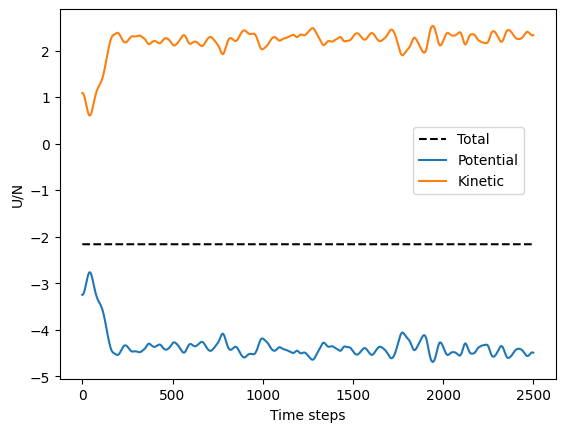

In [14]:
_, ax = plt.subplots()
ax.plot(eq_run[:,0], color='k', ls='--', label='Total')
ax.plot(eq_run[:,1], label = 'Potential')
ax.plot(eq_run[:,2], label = 'Kinetic')
ax.set_xlabel('Time steps')
ax.set_ylabel('U/N')
ax.legend(bbox_to_anchor=(0.95, 0.7), bbox_transform=ax.transAxes);

In [8]:
from molecular_simulations.utils import plot_snapshot
from mayavi import mlab

p = mlab.points3d(
    frames[0, :,0], frames[0, :, 1], frames[0,:, 2], np.ones(shape=(len(pos),)), scale_factor=1
)



In [9]:
p.show_pipeline()

AttributeError: 'Glyph' object has no attribute 'show_pipeline'